# Build the CRC single-cell reference for deconvolution (Fig 4a and b)

In [1]:
import warnings
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load single-cell reference data

In [2]:
# data_dir = "/Users/jysumac/Projects/SpatialDeconv/data/crc_stereo/"
data_dir = "/Users/jbreynier/Desktop/Research/Rabadan_Lab/Spatial_Deconvolution/SpatialDeconv/data/crc_stereo/"
scref = sc.read_h5ad(data_dir + "scref/scref_raw.h5ad")

### Preprocessing

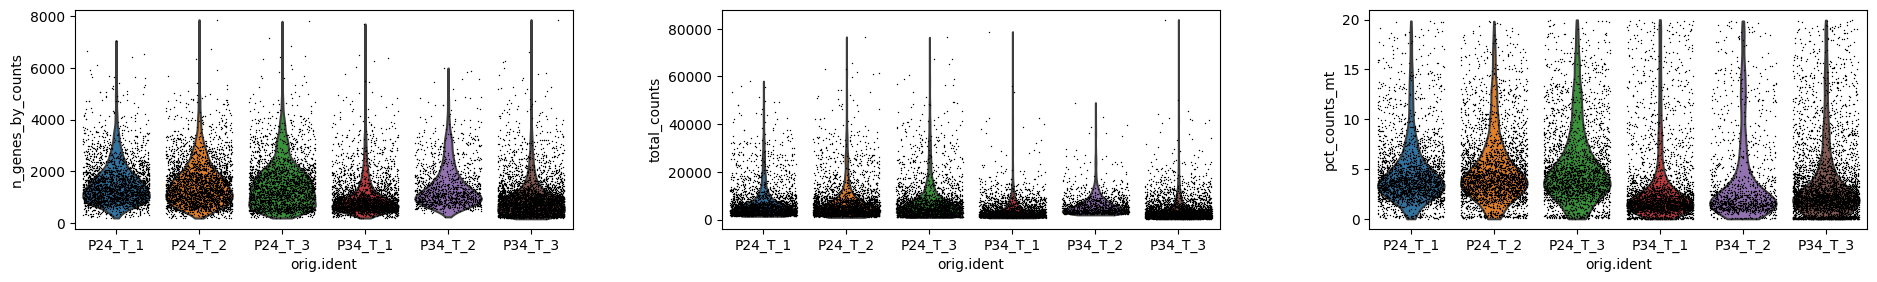

In [3]:
sc.pp.filter_genes(scref, min_cells=10)
scref.var['mt'] = scref.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(scref, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

with plt.rc_context({"figure.figsize": (6, 3)}):
    sc.pl.violin(scref, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
                 groupby='orig.ident', jitter=0.4, multi_panel=True)

In [4]:
scref = scref[scref.obs.n_genes_by_counts < 2500, :]
scref = scref[scref.obs.pct_counts_mt < 5, :]
sc.pp.normalize_total(scref, target_sum=1e4)
scref.layers['norm'] = scref.X.copy()
sc.pp.log1p(scref)
scref.layers['lognorm']=scref.X.copy()
sc.pp.highly_variable_genes(scref)

/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


### Clustering and find marker genes

/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/jbreynier/opt/anaconda3/envs/smoother/lib/p

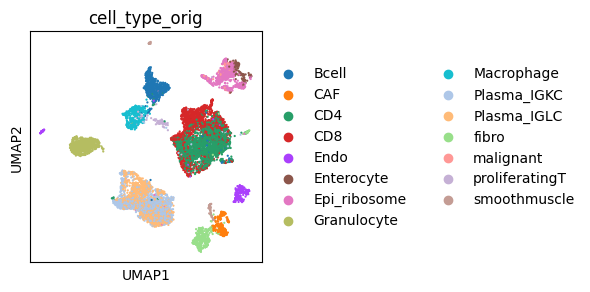

In [5]:
sc.pp.scale(scref, max_value=10)
sc.tl.pca(scref, svd_solver='arpack')
sc.pp.neighbors(scref)
sc.tl.umap(scref)

with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.umap(scref, color = 'cell_type_orig')

/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


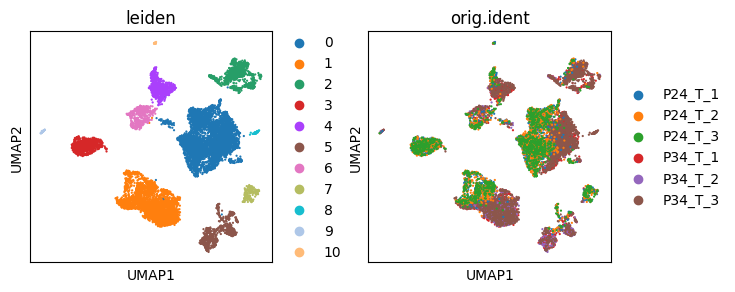

In [6]:
sc.tl.leiden(scref, resolution=0.1)
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.umap(scref, color=['leiden', 'orig.ident'])

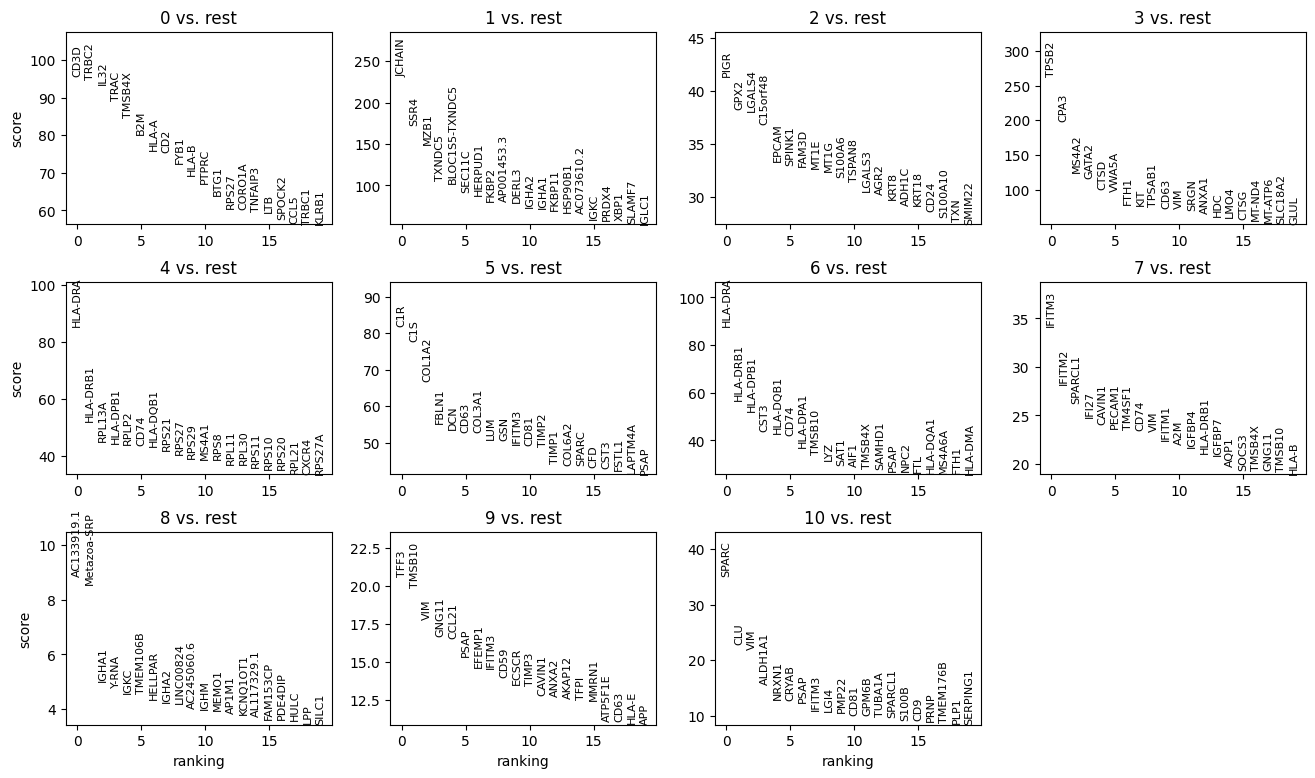

In [7]:
sc.tl.rank_genes_groups(scref, 'leiden', method='t-test',
                        use_raw = False, layer='lognorm')
with plt.rc_context({"figure.figsize": (4, 3)}):
    sc.pl.rank_genes_groups(scref, n_genes=20, sharey=False)

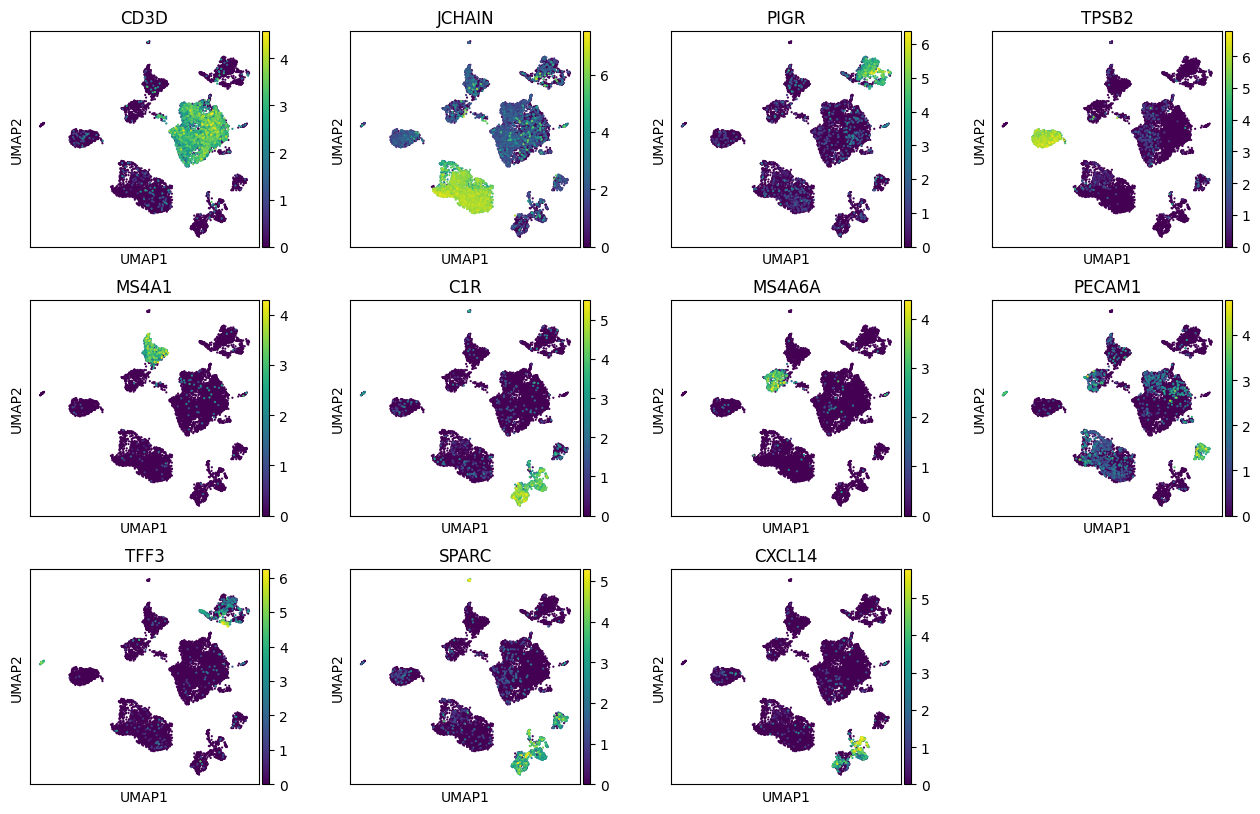

In [8]:
marker_genes = ['CD3D', 'JCHAIN', 'PIGR', 'TPSB2', 'MS4A1', 'C1R', 'MS4A6A', 'PECAM1', 'TFF3', 'SPARC', 'CXCL14']
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.umap(scref, color=[g for g in marker_genes if g in scref.var_names], layer='lognorm')

/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


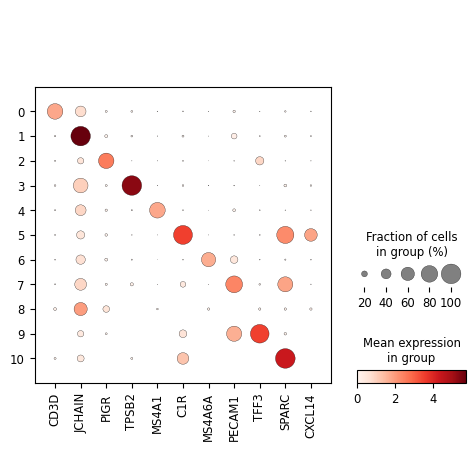

In [9]:
marker_genes = ['CD3D', 'JCHAIN', 'PIGR', 'TPSB2', 'MS4A1', 'C1R', 'MS4A6A', 'PECAM1', 'TFF3', 'SPARC', 'CXCL14']
sc.pl.dotplot(scref, marker_genes, groupby='leiden', layer='lognorm')

### Cell type annotation

In [10]:
cluster_to_ct = {'0': 'T', '1': 'Plasma', '2': 'Epithelial',
                 '3': 'Mast', '4': 'B', '5': 'Fibroblast', 
                 '6': 'Macrophage', '7': 'Endothelial'}

In [11]:
scref = scref[scref.obs['leiden'].isin(cluster_to_ct.keys()), :]
scref.obs['cell_type_major'] = scref.obs['leiden'].replace(cluster_to_ct)

/var/folders/ww/wp54dp116f919zl6ld381gmr0000gn/T/ipykernel_40741/1392850026.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scref.obs['cell_type_major'] = scref.obs['leiden'].replace(cluster_to_ct)


In [12]:
scref.obs['cell_type_major'].value_counts()

cell_type_major
T              4681
Plasma         3191
Epithelial      889
Mast            863
B               687
Fibroblast      677
Macrophage      447
Endothelial     188
Name: count, dtype: int64

/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


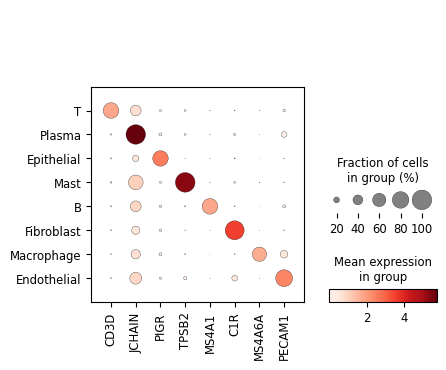

In [13]:
marker_genes = ['CD3D', 'JCHAIN', 'PIGR', 'TPSB2', 'MS4A1', 'C1R', 'MS4A6A', 'PECAM1']
sc.pl.dotplot(scref, marker_genes, groupby='cell_type_major', layer='lognorm')

## Identify subpopulations

### Recluster T cells

#### Preprocessing

In [14]:
tc = ad.AnnData(scref.raw.X, scref.obs, dtype=np.float32)
tc.var_names = scref.raw.var._index
tc = tc[tc.obs['cell_type_major'].isin(['T'])]
sc.pp.filter_genes(tc, min_cells=10)

tc.layers['raw'] = tc.X.copy()
sc.pp.normalize_total(tc, target_sum=1e4)
sc.pp.log1p(tc)
tc.layers['lognorm'] = tc.X.copy()
sc.pp.highly_variable_genes(tc)

/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [15]:
# regress out batch effects
sc.pp.regress_out(tc, ['orig.ident'])

In [16]:
sc.tl.pca(tc, svd_solver='arpack')
sc.pp.neighbors(tc)
sc.tl.umap(tc)

#### Clustering and find marker genes

/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


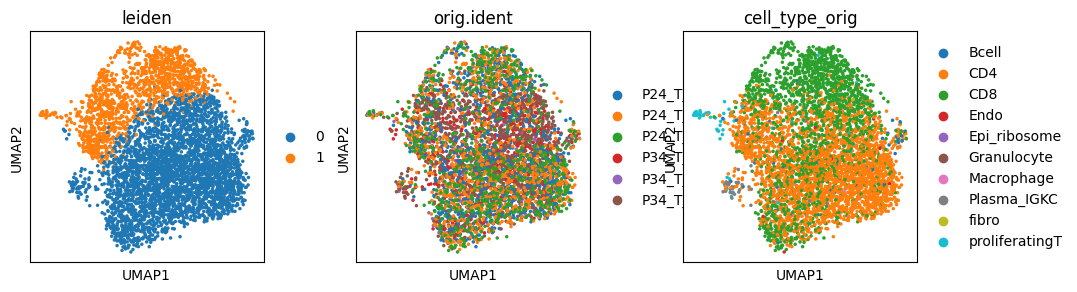

In [17]:
sc.tl.leiden(tc, resolution=0.2)
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.umap(tc, color=['leiden', 'orig.ident', 'cell_type_orig'])

/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


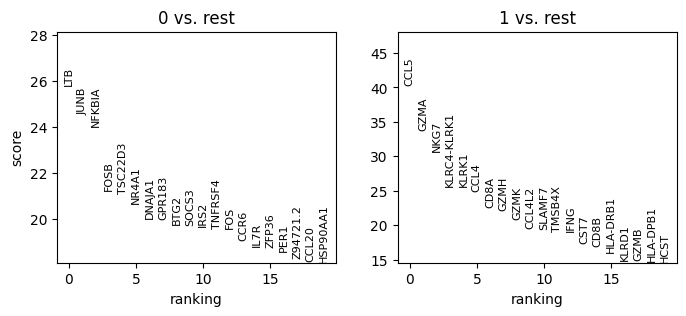

In [18]:
sc.tl.rank_genes_groups(tc, 'leiden', method='t-test', use_raw = False)
with plt.rc_context({"figure.figsize": (4, 3)}):
    sc.pl.rank_genes_groups(tc, n_genes=20, sharey=False)

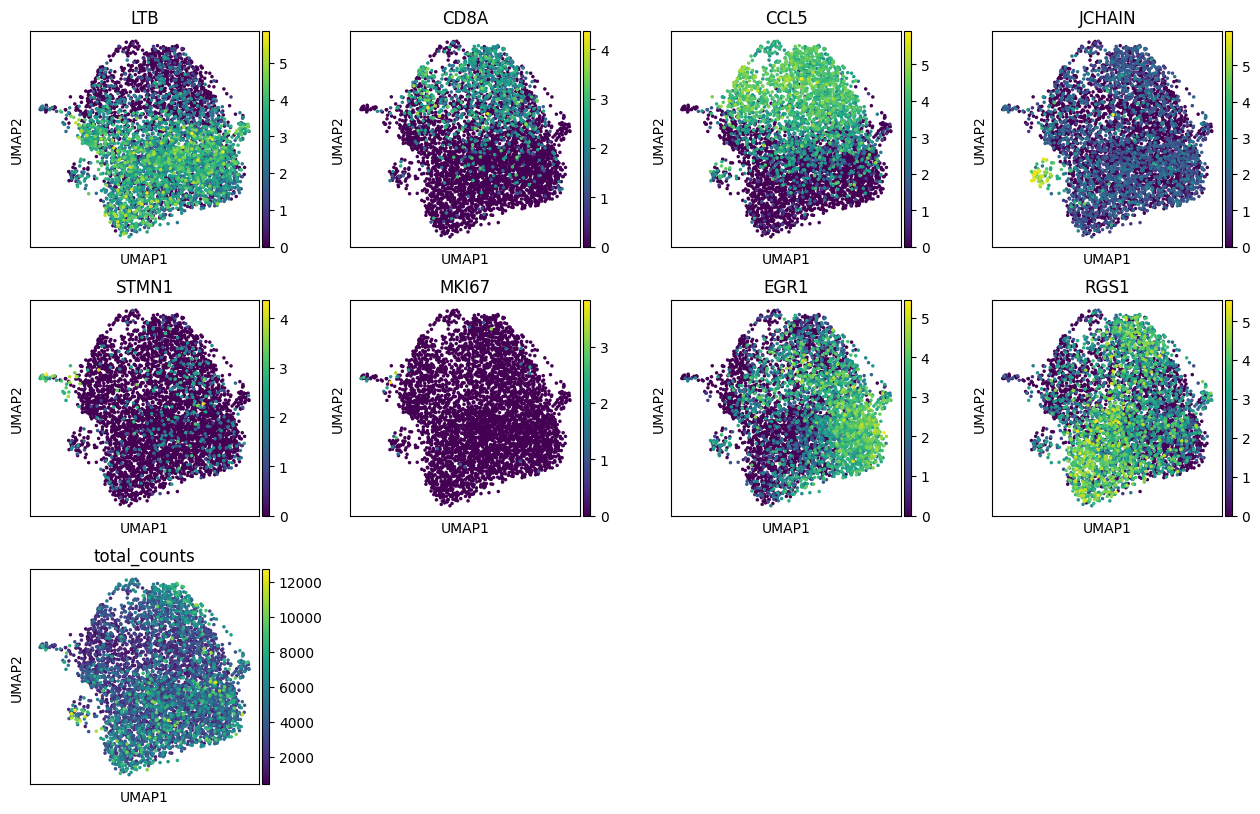

In [19]:
marker_genes = ['LTB', 'CD8A', 'CCL5', 'JCHAIN', 'STMN1', 'MKI67', 'EGR1', 'RGS1']
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.umap(tc, color=[g for g in marker_genes if g in tc.var_names] + ['total_counts'], layer = 'lognorm')

#### Cell type annotation

In [20]:
cluster_to_ct = {'0': 'T_CD4', '1': 'T_CD8'}

tc = tc[tc.obs['leiden'].isin(cluster_to_ct.keys()), :]
tc.obs['t_subtype'] = tc.obs['leiden'].replace(cluster_to_ct)

/var/folders/ww/wp54dp116f919zl6ld381gmr0000gn/T/ipykernel_40741/722276102.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tc.obs['t_subtype'] = tc.obs['leiden'].replace(cluster_to_ct)


In [21]:
tc.obs['t_subtype'].value_counts()

t_subtype
T_CD4    3404
T_CD8    1277
Name: count, dtype: int64

/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


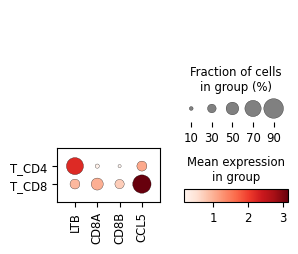

In [22]:
marker_genes = ['LTB', 'CD8A', 'CD8B', 'CCL5']
sc.pl.dotplot(tc, marker_genes, groupby='t_subtype', layer='lognorm')

### Recluster plasma cells

#### Preprocessing

In [23]:
pc = ad.AnnData(scref.raw.X, scref.obs, dtype=np.float32)
pc.var_names = scref.raw.var._index
pc = pc[pc.obs['cell_type_major'].isin(['Plasma'])]
sc.pp.filter_genes(pc, min_cells=10)

pc.layers['raw'] = pc.X.copy()
sc.pp.normalize_total(pc, target_sum=1e4)
sc.pp.log1p(pc)
pc.layers['lognorm'] = pc.X.copy()
sc.pp.highly_variable_genes(pc)

/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [24]:
# regress out batch effects
sc.pp.regress_out(pc, ['orig.ident'])

In [25]:
sc.tl.pca(pc, svd_solver='arpack')
sc.pp.neighbors(pc)
sc.tl.umap(pc)

#### Clustering and find marker genes

/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


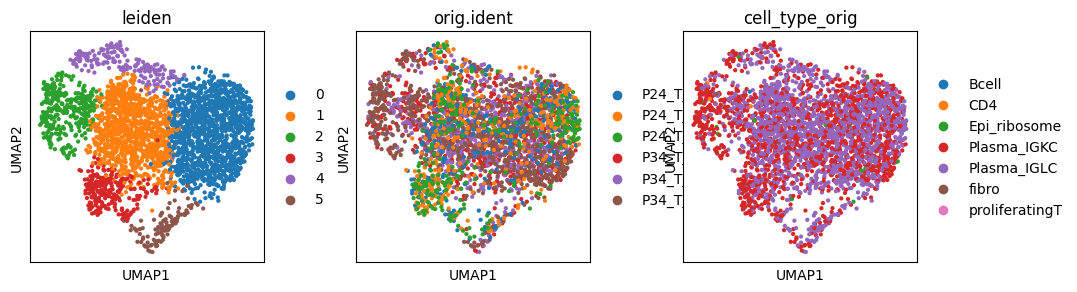

In [26]:
sc.tl.leiden(pc, resolution=0.5)
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.umap(pc, color=['leiden', 'orig.ident', 'cell_type_orig'])

/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning

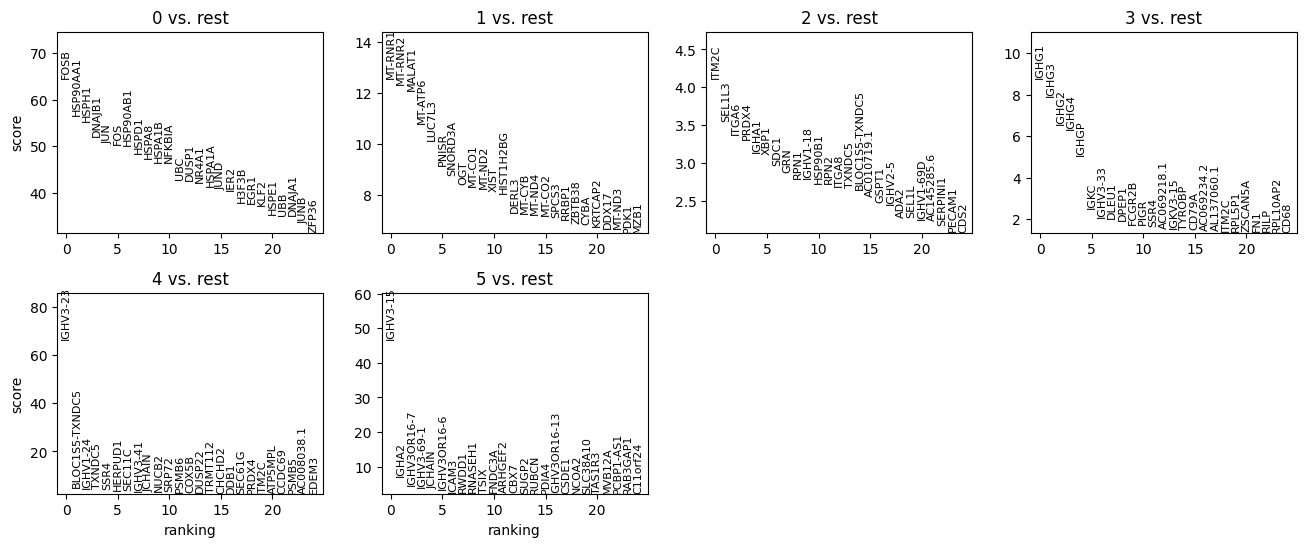

In [27]:
sc.tl.rank_genes_groups(pc, 'leiden', method='t-test', use_raw = False)
with plt.rc_context({"figure.figsize": (4, 3)}):
    sc.pl.rank_genes_groups(pc, n_genes=25, sharey=False)

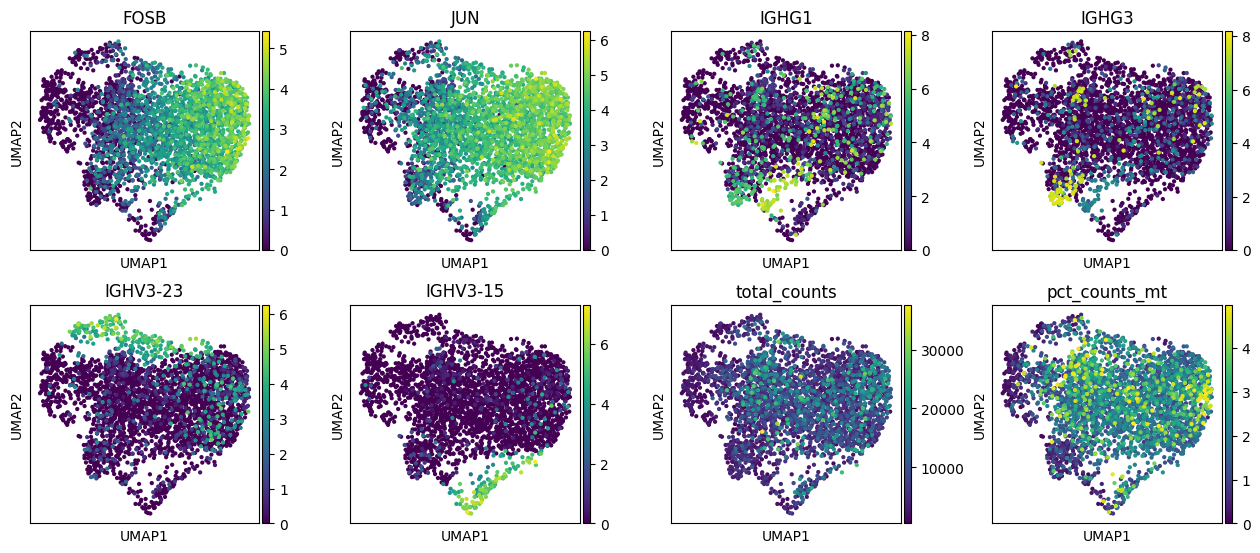

In [28]:
marker_genes = ['FOSB', 'JUN', 'IGHG1', 'IGHG3', 'IGHV3-23', 'IGHV3-15']
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.umap(pc, color=[g for g in marker_genes if g in pc.var_names] + ['total_counts', 'pct_counts_mt'], 
               layer = 'lognorm')

#### Cell type annotation

In [29]:
cluster_to_ct = {'0': 'PC_IgA_FOS/JUN', '1': 'PC_IgA_FOS/JUN', '2': 'PC_IgA', '3': 'PC_IgG', '6': 'PC_IgG'}

pc = pc[pc.obs['leiden'].isin(cluster_to_ct.keys()), :]
pc.obs['pc_subtype'] = pc.obs['leiden'].replace(cluster_to_ct)

/var/folders/ww/wp54dp116f919zl6ld381gmr0000gn/T/ipykernel_40741/3380433836.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  pc.obs['pc_subtype'] = pc.obs['leiden'].replace(cluster_to_ct)


In [30]:
pc.obs['pc_subtype'].value_counts()

pc_subtype
PC_IgA_FOS/JUN    2325
PC_IgA             334
PC_IgG             254
Name: count, dtype: int64

/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


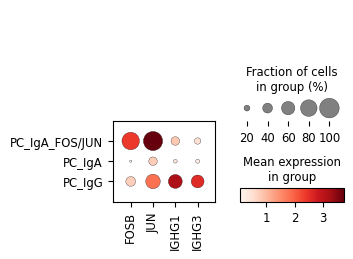

In [31]:
# marker genes from https://www.cell.com/cell/pdf/S0092-8674(21)00945-4.pdf
# markers_pc = ['IGHG1', 'IGHG3', 'IGHG4', 'STMN1', 'HMGB2']

markers_pc = ['FOSB', 'JUN', 'IGHG1', 'IGHG3']
sc.pl.dotplot(pc, markers_pc, groupby='pc_subtype', layer='lognorm')

#### Check IgA/IgG expression

/var/folders/ww/wp54dp116f919zl6ld381gmr0000gn/T/ipykernel_40741/3330702328.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  [g for g in pc.var_names[pc.var_names.str.contains('IGH(G|A)', regex=True)]], layer = 'lognorm')


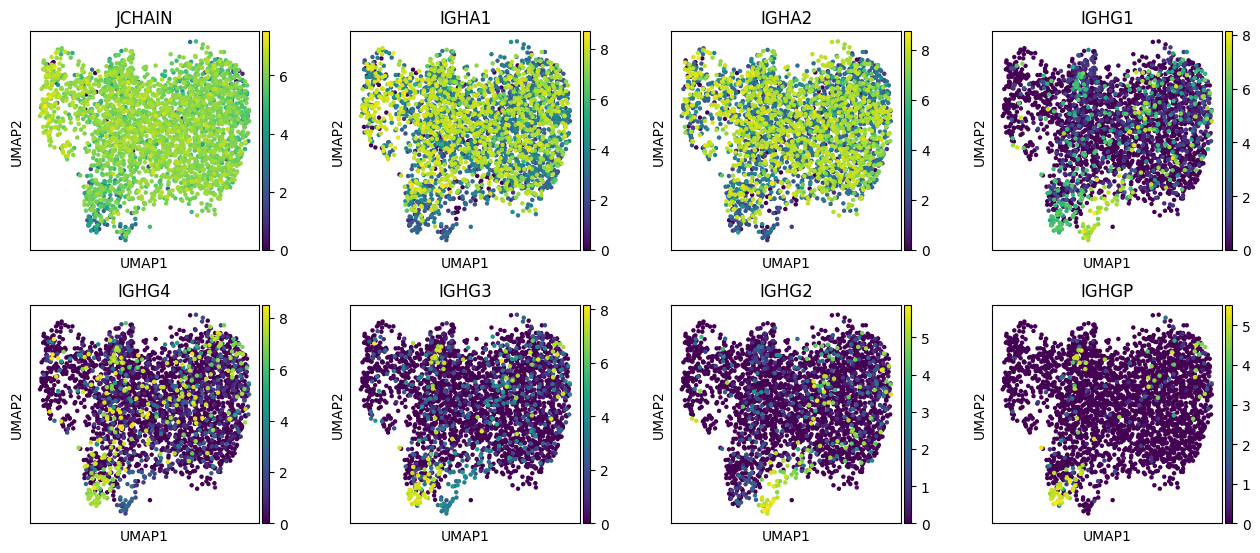

In [32]:
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.umap(pc, color=['JCHAIN'] + 
                   [g for g in pc.var_names[pc.var_names.str.contains('IGH(G|A)', regex=True)]], layer = 'lognorm')

### Recluster epithelial cells

#### Preprocessing

In [33]:
epi = ad.AnnData(scref.raw.X, scref.obs, dtype=np.float32)
epi.var_names = scref.raw.var._index
epi = epi[epi.obs['cell_type_major'].isin(['Epithelial'])]
sc.pp.filter_genes(epi, min_cells=10)

epi.layers['raw'] = epi.X.copy()
sc.pp.normalize_total(epi, target_sum=1e4)
sc.pp.log1p(epi)
epi.layers['lognorm'] = epi.X.copy()
sc.pp.highly_variable_genes(epi)

/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [34]:
# almost all from one batch, no need for correction
epi.obs['orig.ident'].value_counts()

orig.ident
P34_T_3    551
P34_T_1    241
P34_T_2     40
P24_T_2     22
P24_T_3     19
P24_T_1     16
Name: count, dtype: int64

In [35]:
sc.pp.scale(epi, max_value=10)
sc.tl.pca(epi, svd_solver='arpack')
sc.pp.neighbors(epi)
sc.tl.umap(epi)

#### Clustering and find marker genes

/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


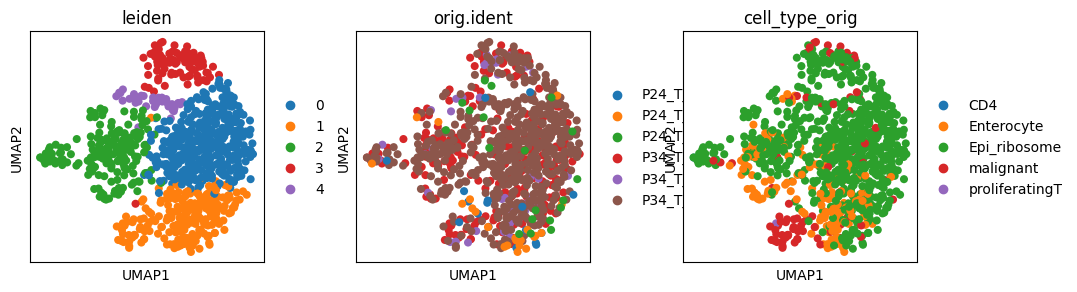

In [36]:
sc.tl.leiden(epi, resolution=0.4)
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.umap(epi, color=['leiden', 'orig.ident', 'cell_type_orig'])

/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning

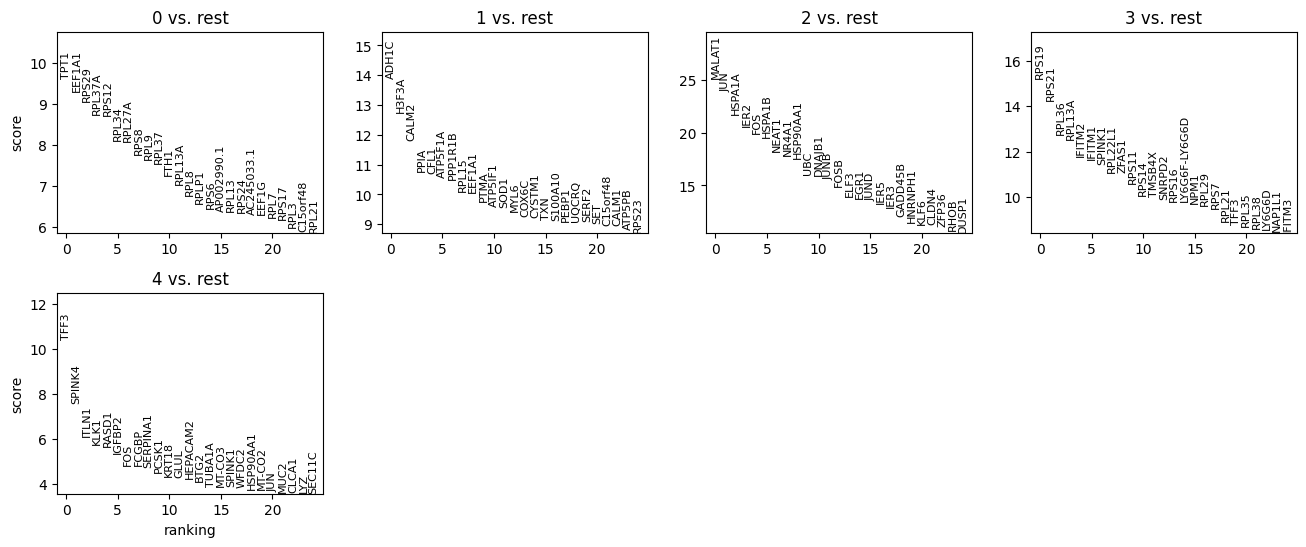

In [37]:
sc.tl.rank_genes_groups(epi, 'leiden', method='t-test')
with plt.rc_context({"figure.figsize": (4, 3)}):
    sc.pl.rank_genes_groups(epi, n_genes=25, sharey=False)

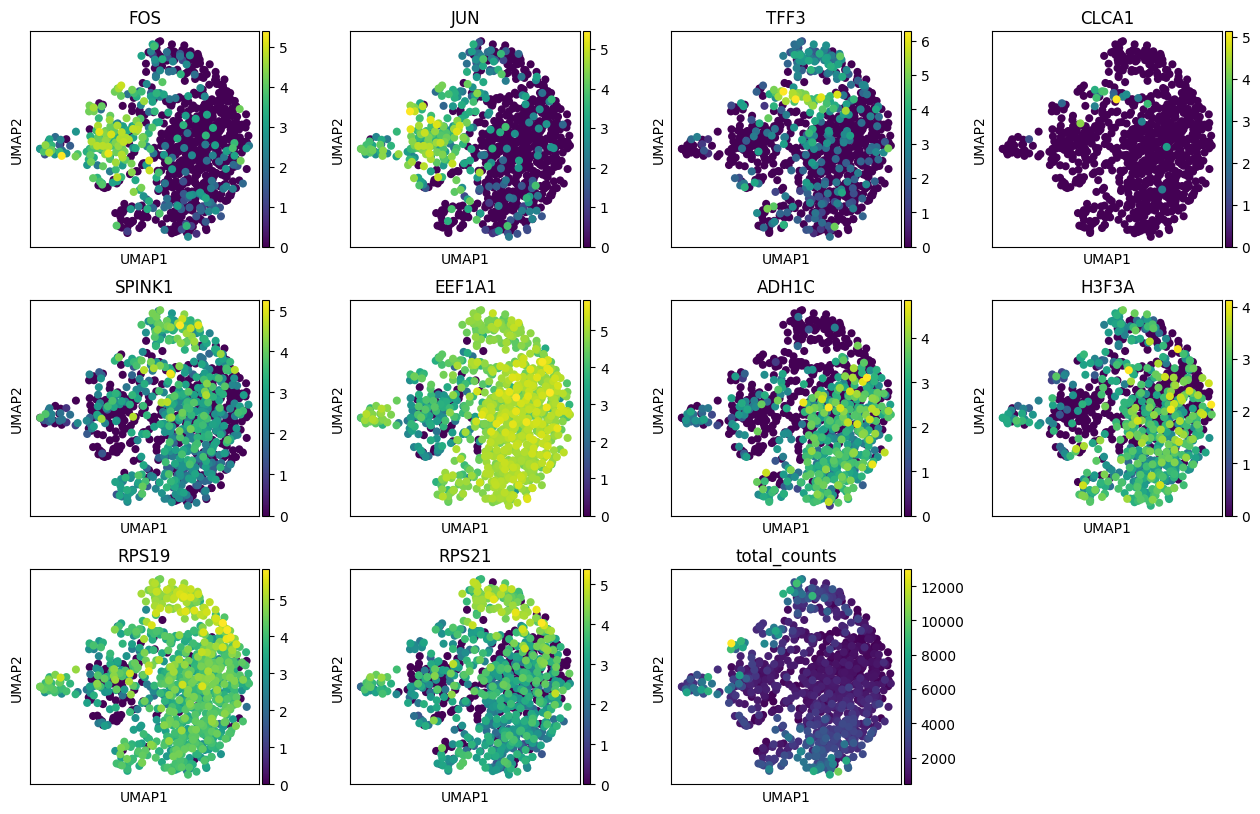

In [38]:
# 0: ADH1C
# 1: ADH1C
# 2: pEpi03 (Fos, Jun)
# 3: pEpi35 (CLCA1, TFF3, SPINK1)
# 4: pEpi35 (CLCA1, TFF3, SPINK1)

#marker_genes = ['ADH1C', 'PIGR', 'FTH1', 'C15orf48', 'JUN', 'FOS', 'SPINK1', 'TFF3', 'CLCA1', 'MKI67']
marker_genes = ['FOS', 'JUN', 'TFF3', 'CLCA1', 'SPINK1',
                'EEF1A1', 'ADH1C', 'H3F3A', 
                'RPS19', 'RPS21']
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.umap(epi, color=[g for g in marker_genes if g in epi.var_names] + ['total_counts'], layer = 'lognorm')

/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


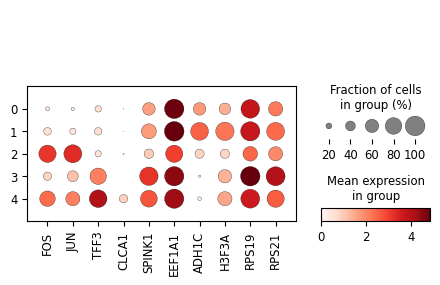

In [39]:
marker_genes = ['FOS', 'JUN', 'TFF3', 'CLCA1', 'SPINK1',
                'EEF1A1', 'ADH1C', 'H3F3A', 
                'RPS19', 'RPS21']
sc.pl.dotplot(epi, marker_genes, groupby='leiden', layer='lognorm')

#### Cell type annotation

In [40]:
cluster_to_ct = {'0': 'Epi_ADH1C', '1': 'Epi_ADH1C', '2': 'Epi_FOS/JUN', '3': 'Epi_TFF3', '4': 'Epi_TFF3'}

epi = epi[epi.obs['leiden'].isin(cluster_to_ct.keys()), :]
epi.obs['epi_subtype'] = epi.obs['leiden'].replace(cluster_to_ct)

/var/folders/ww/wp54dp116f919zl6ld381gmr0000gn/T/ipykernel_40741/48904310.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  epi.obs['epi_subtype'] = epi.obs['leiden'].replace(cluster_to_ct)


In [41]:
epi.obs['epi_subtype'].value_counts()

epi_subtype
Epi_ADH1C      590
Epi_FOS/JUN    177
Epi_TFF3       122
Name: count, dtype: int64

/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


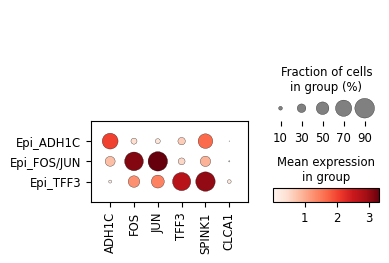

In [42]:
marker_genes = ['ADH1C', 'FOS', 'JUN', 'TFF3', 'SPINK1', 'CLCA1']
sc.pl.dotplot(epi, marker_genes, groupby='epi_subtype', layer='lognorm')

#### Check proliferation marker expression

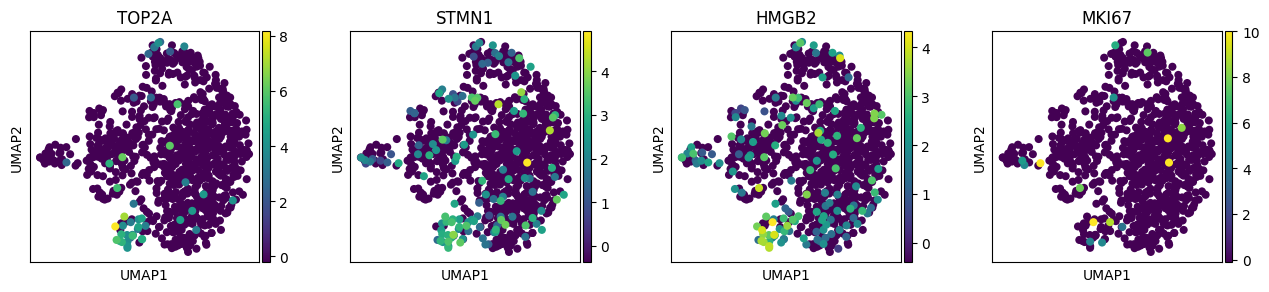

In [43]:
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.umap(epi, color=['TOP2A', 'STMN1', 'HMGB2', 'MKI67'])

### Recluster fibroblasts

#### Preprocessing

In [44]:
fib = ad.AnnData(scref.raw.X, scref.obs, dtype=np.float32)
fib.var_names = scref.raw.var._index
fib = fib[fib.obs['cell_type_major'].isin(['Fibroblast'])]
sc.pp.filter_genes(fib, min_cells=10)

fib.layers['raw'] = fib.X.copy()
sc.pp.normalize_total(fib, target_sum=1e4)
sc.pp.log1p(fib)
fib.layers['lognorm'] = fib.X.copy()
sc.pp.highly_variable_genes(fib)

/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [45]:
# almost all from one batch, no need for correction
fib.obs['orig.ident'].value_counts()

orig.ident
P34_T_1    242
P34_T_3    180
P34_T_2    145
P24_T_1     39
P24_T_2     38
P24_T_3     33
Name: count, dtype: int64

In [46]:
sc.pp.scale(fib, max_value=10)
sc.tl.pca(fib, svd_solver='arpack')
sc.pp.neighbors(fib)
sc.tl.umap(fib)

#### Clustering and find marker genes

/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


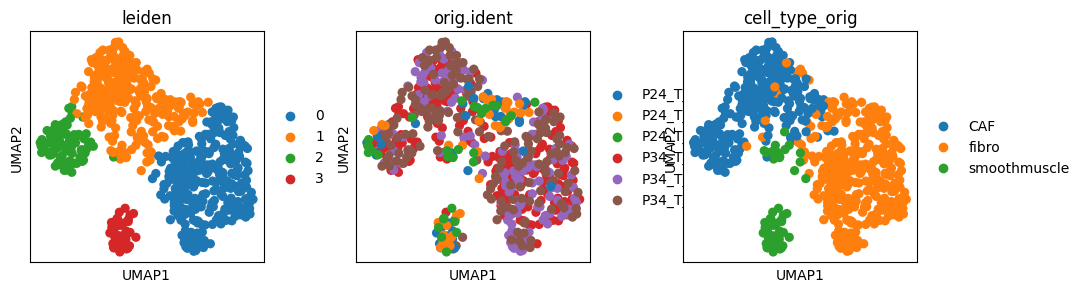

In [47]:
sc.tl.leiden(fib, resolution=0.3)
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.umap(fib, color=['leiden', 'orig.ident', 'cell_type_orig'])

/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


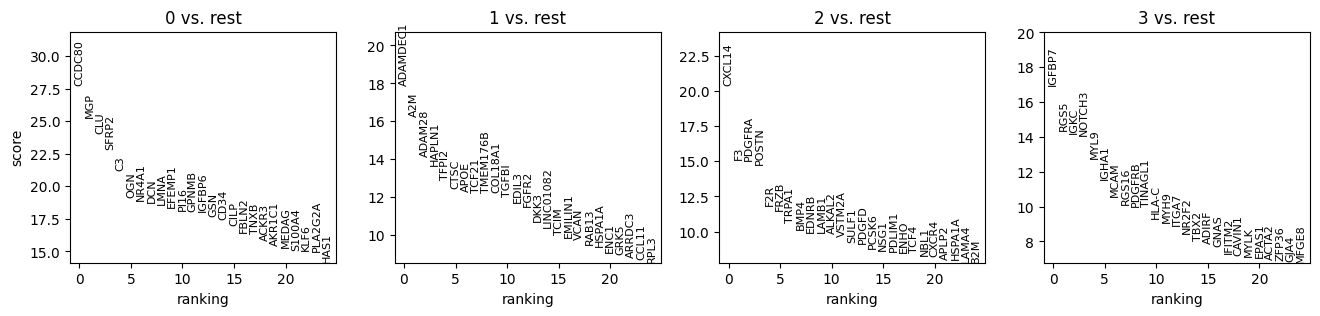

In [48]:
sc.tl.rank_genes_groups(fib, 'leiden', method='t-test')
with plt.rc_context({"figure.figsize": (4, 3)}):
    sc.pl.rank_genes_groups(fib, n_genes=25, sharey=False)

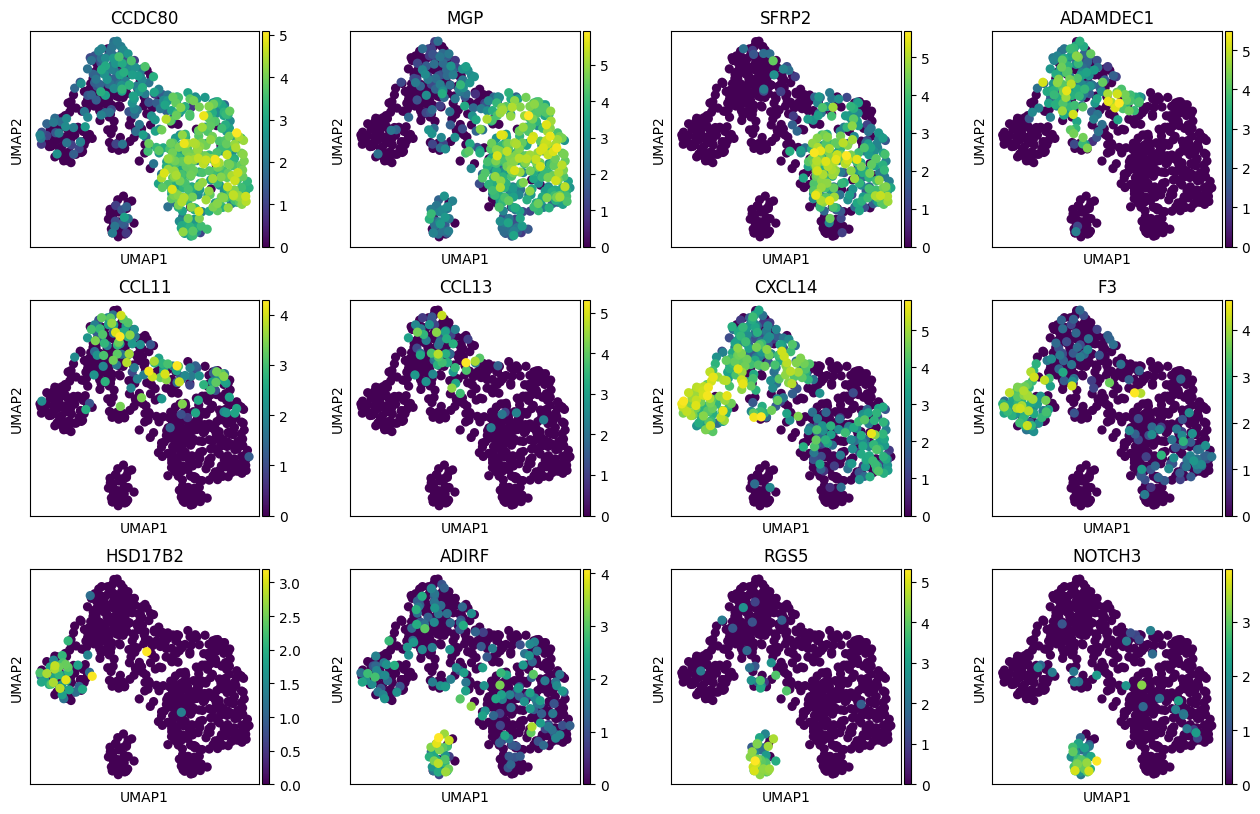

In [49]:
# https://www.cell.com/cell/pdf/S0092-8674(21)00945-4.pdf
# marker_genes = ['CCDC80', 'MGP', 'SFRP2'] # 0: Matrix/stem niche fibro
# marker_genes = ['ADAMDEC1', 'APOE', 'CCL11', 'CCL13', 'TCF21'] # 1: CCL8 fibro
# marker_genes = ['CXCL14', 'F3', 'PDGFRA', 'HSD17B2', 
#                 'LUM', 'CTSK', 'CTHRC1', 'RARRES2', 'SERPINF1'] # CXCL14
# marker_genes = ['ADIRF', 'RERGL', 'PLN', 'MYL9', 'NOTCH3', 'ACTA2'] # smooth muscles

marker_genes = ['CCDC80', 'MGP', 'SFRP2',
                'ADAMDEC1', 'CCL11', 'CCL13',
                'CXCL14', 'F3', 'HSD17B2',
                'ADIRF', 'RGS5', 'NOTCH3']
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.umap(fib, color=[g for g in marker_genes if g in fib.var_names], layer = 'lognorm')

/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


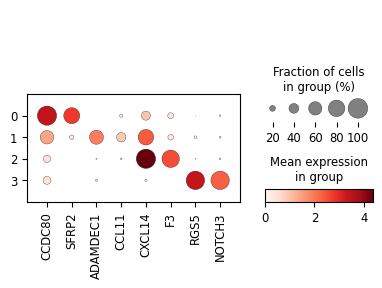

In [50]:
marker_genes = ['CCDC80', 'SFRP2',
                'ADAMDEC1', 'CCL11',
                'CXCL14', 'F3',
                'RGS5', 'NOTCH3']
sc.pl.dotplot(fib, marker_genes, groupby='leiden', layer='lognorm')

#### Cell type annotation

In [51]:
cluster_to_ct = {'0': 'Fibro_matrix', '1': 'Fibro_CCL8', '2': 'Fibro_CXCL14', '3': 'Smooth_muscle'}

fib = fib[fib.obs['leiden'].isin(cluster_to_ct.keys()), :]
fib.obs['fib_subtype'] = fib.obs['leiden'].replace(cluster_to_ct)

/var/folders/ww/wp54dp116f919zl6ld381gmr0000gn/T/ipykernel_40741/2177466179.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  fib.obs['fib_subtype'] = fib.obs['leiden'].replace(cluster_to_ct)


In [52]:
fib.obs['fib_subtype'].value_counts()

fib_subtype
Fibro_matrix     303
Fibro_CCL8       255
Fibro_CXCL14      82
Smooth_muscle     37
Name: count, dtype: int64

/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


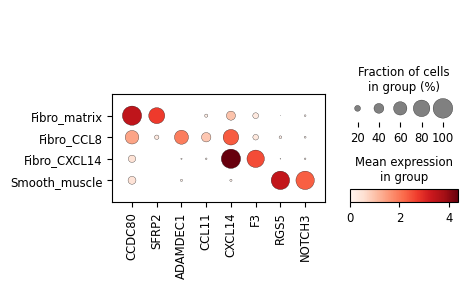

In [53]:
marker_genes = ['CCDC80', 'SFRP2',
                'ADAMDEC1', 'CCL11',
                'CXCL14', 'F3',
                'RGS5', 'NOTCH3']
sc.pl.dotplot(fib, marker_genes, groupby='fib_subtype', layer='lognorm')

## Update cell type annotations

### Merge subtypes

In [54]:
scref.obs['cell_type_sub'] = ''

scref.obs['cell_type_sub'][tc.obs['t_subtype'].index] = tc.obs['t_subtype'].astype(str)
scref.obs['cell_type_sub'][pc.obs['pc_subtype'].index] = pc.obs['pc_subtype'].astype(str)
scref.obs['cell_type_sub'][epi.obs['epi_subtype'].index] = epi.obs['epi_subtype'].astype(str)
scref.obs['cell_type_sub'][fib.obs['fib_subtype'].index] = fib.obs['fib_subtype'].astype(str)

scref.obs['cell_type_sub'][scref.obs['cell_type_major'] == 'Mast'] = 'Mast'
scref.obs['cell_type_sub'][scref.obs['cell_type_major'] == 'B'] = 'B'
scref.obs['cell_type_sub'][scref.obs['cell_type_major'] == 'Macrophage'] = 'Macrophage'
scref.obs['cell_type_sub'][scref.obs['cell_type_major'] == 'Endothelial'] = 'Endothelial'

# keep annotated cells only
scref = scref[scref.obs['cell_type_sub'] != '', :]

/var/folders/ww/wp54dp116f919zl6ld381gmr0000gn/T/ipykernel_40741/1716070294.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scref.obs['cell_type_sub'][tc.obs['t_subtype'].index] = tc.obs['t_subtype'].astype(str)
/var/folders/ww/wp54dp116f919zl6ld381gmr0000gn/T/ipykernel_40741/1716070294.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scref.obs['cell_type_sub'][pc.obs['pc_subtype'].index] = pc.obs['pc_subtype'].astype(str)
/var/folders/ww/wp54dp116f919zl6ld381gmr0000gn/T/ipykernel_40741/1716070294.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in

In [55]:
scref.obs['cell_type_sub'].value_counts()

cell_type_sub
T_CD4             3404
PC_IgA_FOS/JUN    2325
T_CD8             1277
Mast               863
B                  687
Epi_ADH1C          590
Macrophage         447
PC_IgA             334
Fibro_matrix       303
Fibro_CCL8         255
PC_IgG             254
Endothelial        188
Epi_FOS/JUN        177
Epi_TFF3           122
Fibro_CXCL14        82
Smooth_muscle       37
Name: count, dtype: int64

#### Visualize the CRC single-cell reference atlas

UMAP of all cell types (Figure 5a):

In [56]:
redo_palette = {
 "PC_IgA": '#1f77b4',
 "PC_IgA_FOS/JUN": '#ff7f0e',
 "B": '#279e68',
 "PC_IgG": '#d62728',
 "Endothelial": '#aa40fc',
 "Epi_ADH1C": '#8c564b',
 "Epi_FOS/JUN": '#e377c2',
 "Epi_TFF3": '#b5bd61',
 "Fibro_CCL8": '#17becf',
 "Fibro_CXCL14": '#aec7e8',
 "Fibro_matrix": '#ffbb78',
 "Macrophage": '#98df8a',
 "Mast": '#ff9896',
 "Smooth_muscle": '#c5b0d5',
 "T_CD4": '#c49c94',
 "T_CD8": '#f7b6d2'
}

/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


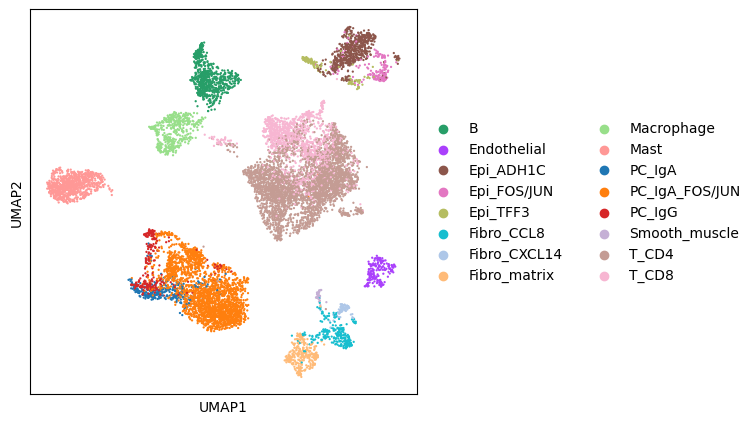

In [57]:
with plt.rc_context({"figure.figsize": (5, 5)}):
    sc.pl.umap(scref, color = 'cell_type_sub', title = '', palette=redo_palette, save="umap_sc_recolor.pdf")

#### Visualize marker gene expression

Marker gene expression for all cell types (Figure 5b):

/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


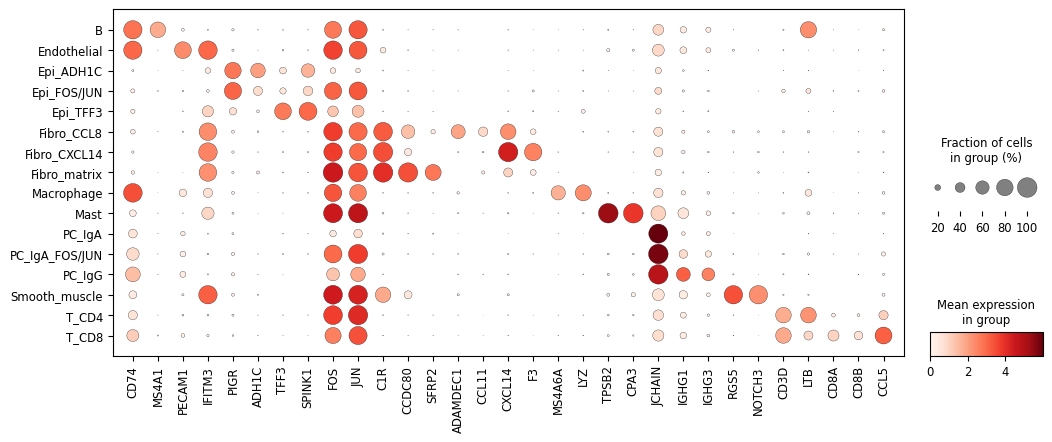

In [58]:
marker_genes = ['CD74', 'MS4A1',
                'PECAM1', 'IFITM3',
                'PIGR', 'ADH1C', 'TFF3', 'SPINK1', 'FOS', 'JUN',
                'C1R', 'CCDC80', 'SFRP2', 'ADAMDEC1', 'CCL11', 'CXCL14', 'F3', 
                'MS4A6A', 'LYZ',
                'TPSB2', 'CPA3',
                'JCHAIN', 'IGHG1', 'IGHG3',
                'RGS5', 'NOTCH3',
                'CD3D', 'LTB', 'CD8A', 'CD8B', 'CCL5',
               ]


sc.pl.dotplot(scref, marker_genes, 
              groupby='cell_type_sub', layer='lognorm',
             figsize=(12, 4.5))

Fibroblast gene expression for all cell types (Supplementary Fig 24c):

In [59]:
sc.set_figure_params(scanpy=True, fontsize=14, dpi_save=300)
marker_genes_fibroblast = ['ADAMDEC1', 'APOE', 'CCL11',
                'CXCL14', 'F3', 'BMP4',
                'CCDC80', 'SFRP2', 'MGP'
]

fibro_dotplot = sc.pl.dotplot(scref, marker_genes_fibroblast,
              groupby='cell_type_sub', layer='lognorm', show=False)

/Users/jbreynier/opt/anaconda3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


In [60]:
ax = fibro_dotplot["mainplot_ax"]
for l in ax.get_xticklabels():
    l.set_style("italic")

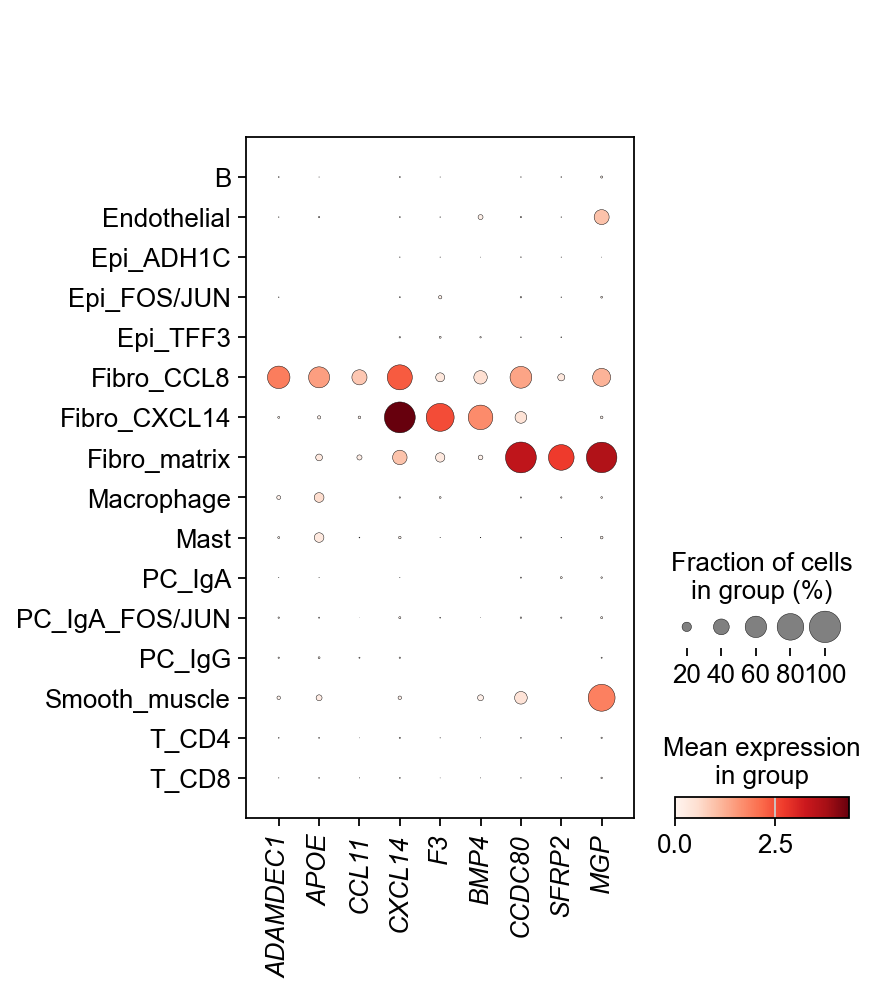

In [61]:
plt.savefig("dotplot_sc_marker_genes_fibroblast.png", bbox_inches="tight", dpi=300)
plt.show()

## Extract marker genes and prepare inputs

In [62]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    sc.tl.rank_genes_groups(scref, 'cell_type_sub', method='wilcoxon', 
                            use_raw = False, layer='lognorm')
    markers_df = sc.get.rank_genes_groups_df(scref, group = None,
                                             pval_cutoff = 0.01, log2fc_min = 1)

In [63]:
markers_df

group       names     scores  logfoldchanges          pvals  \
0         B     HLA-DRA  39.035095        6.057676   0.000000e+00   
1         B    HLA-DRB1  34.251717        4.591818  4.112353e-257   
2         B        CD74  32.693783        3.616461  1.914146e-234   
3         B    HLA-DQB1  32.556309        4.665591  1.704750e-232   
4         B       MS4A1  32.388462        8.852423  3.989831e-230   
...     ...         ...        ...             ...            ...   
8405  T_CD8       STK39   3.477134        1.238453   5.068043e-04   
8406  T_CD8    APOBEC3D   3.466386        1.853687   5.275049e-04   
8407  T_CD8  AC010186.2   3.454777        1.118211   5.507485e-04   
8408  T_CD8      HSPB11   3.454632        1.174343   5.510450e-04   
8409  T_CD8      ZNF217   3.453979        1.067003   5.523811e-04   

          pvals_adj  
0      0.000000e+00  
1     4.732084e-253  
2     1.468405e-230  
3     9.808280e-229  
4     1.836439e-226  
...             ...  
8405   8.923943e-03  
8406   9.210923e-03  
8407   9.571132e-03  
8408   9.571132e-03  
8409   9.587103e-03  

[8410 rows x 6 columns]

### Use different filtering criteria

#### All informative genes

In [64]:
markers_nm0 = markers_df.pivot_table(index='names', columns='group',
                                     values='logfoldchanges', fill_value=0)
markers_nm0 = markers_nm0.loc[((markers_nm0 >= 1).sum(1) < 10),:]

print(markers_nm0.shape)
markers_nm0.to_csv(f"{data_dir}/scref/markers_nm0.csv")

(4992, 16)


#### Top50 marker genes

In [65]:
markers_nm50 = markers_df.sort_values(['group', 'logfoldchanges'],
                                    ascending=False).groupby('group').head(50)
markers_nm50 = markers_nm50.pivot_table(index='names', columns='group',
                                    values='logfoldchanges', fill_value=0)
print(markers_nm50.shape)
markers_nm50.to_csv(f"{data_dir}/scref/markers_nm50.csv")

(695, 16)


### Calculate averaged expression profiles

In [66]:
from smoother.simulation.utils import grouped_obs_mean
ref_exp = grouped_obs_mean(scref, group_key='cell_type_sub', layer = 'norm')

In [67]:
ref_exp_m = ref_exp.loc[markers_nm0.index,:]
ref_exp_m.to_csv(f"{data_dir}/scref/ref_avg_count_nm0.csv")
np.log1p(ref_exp_m).to_csv(f"{data_dir}/scref/ref_avg_logcount_nm0.csv")

In [68]:
ref_exp_m = ref_exp.loc[markers_nm50.index,:]
ref_exp_m.to_csv(f"{data_dir}/scref/ref_avg_count_nm50.csv")
np.log1p(ref_exp_m).to_csv(f"{data_dir}/scref/ref_avg_logcount_nm50.csv")

## Save the single-cell reference data

In [69]:
scref.obs['cell_type_sub'].to_csv(f"{data_dir}/scref/cell_type_sub.csv")

In [70]:
scref._raw._var.rename(columns={'_index': 'features'}, inplace=True)
scref.write_h5ad(f"{data_dir}/scref/scref_w_sub.h5ad")

### Reload results

In [71]:
# data_dir = "/Users/jysumac/Projects/SpatialDeconv/data/crc_stereo/"
data_dir = "/Users/jbreynier/Desktop/Research/Rabadan_Lab/Spatial_Deconvolution/SpatialDeconv/data/crc_stereo/"
scref = sc.read_h5ad(data_dir + "scref/scref_w_sub.h5ad")